In [36]:
import os
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold
import time
start = time.time()

In [2]:
DATA_PATH = 'E:/Projects/datacup/'
seed = 32

In [3]:
train = pd.read_csv(DATA_PATH+'performance_train.csv')
test = pd.read_csv(DATA_PATH+'performance_test.csv')

In [4]:
N = len(train)

In [5]:
list_stacks = os.listdir('Stacksfull/')

In [6]:
list_stacks = list(filter(lambda x: x[-4:] == '.npy', list_stacks))

In [7]:
list_stacks

['0.91602_MetaLGBM_full.npy', '0.91693_MetaCB2_full.npy']

In [8]:
X_meta = np.zeros((N+len(test),1+len(list_stacks)))
X_meta[:N,-1] = train['Default']
X_meta[N:,-1] = np.nan

In [9]:
for i,stack in enumerate(list_stacks):
    meta = np.load('Stacksfull/'+stack)
    X_meta[:,i] = meta[:,1]

In [10]:
pd.DataFrame(X_meta).corr()

,0,1,2
0,1.000000,0.977850,0.663481
1,0.977850,1.000000,0.667051
2,0.663481,0.667051,1.000000


In [11]:
from sklearn.metrics import roc_curve

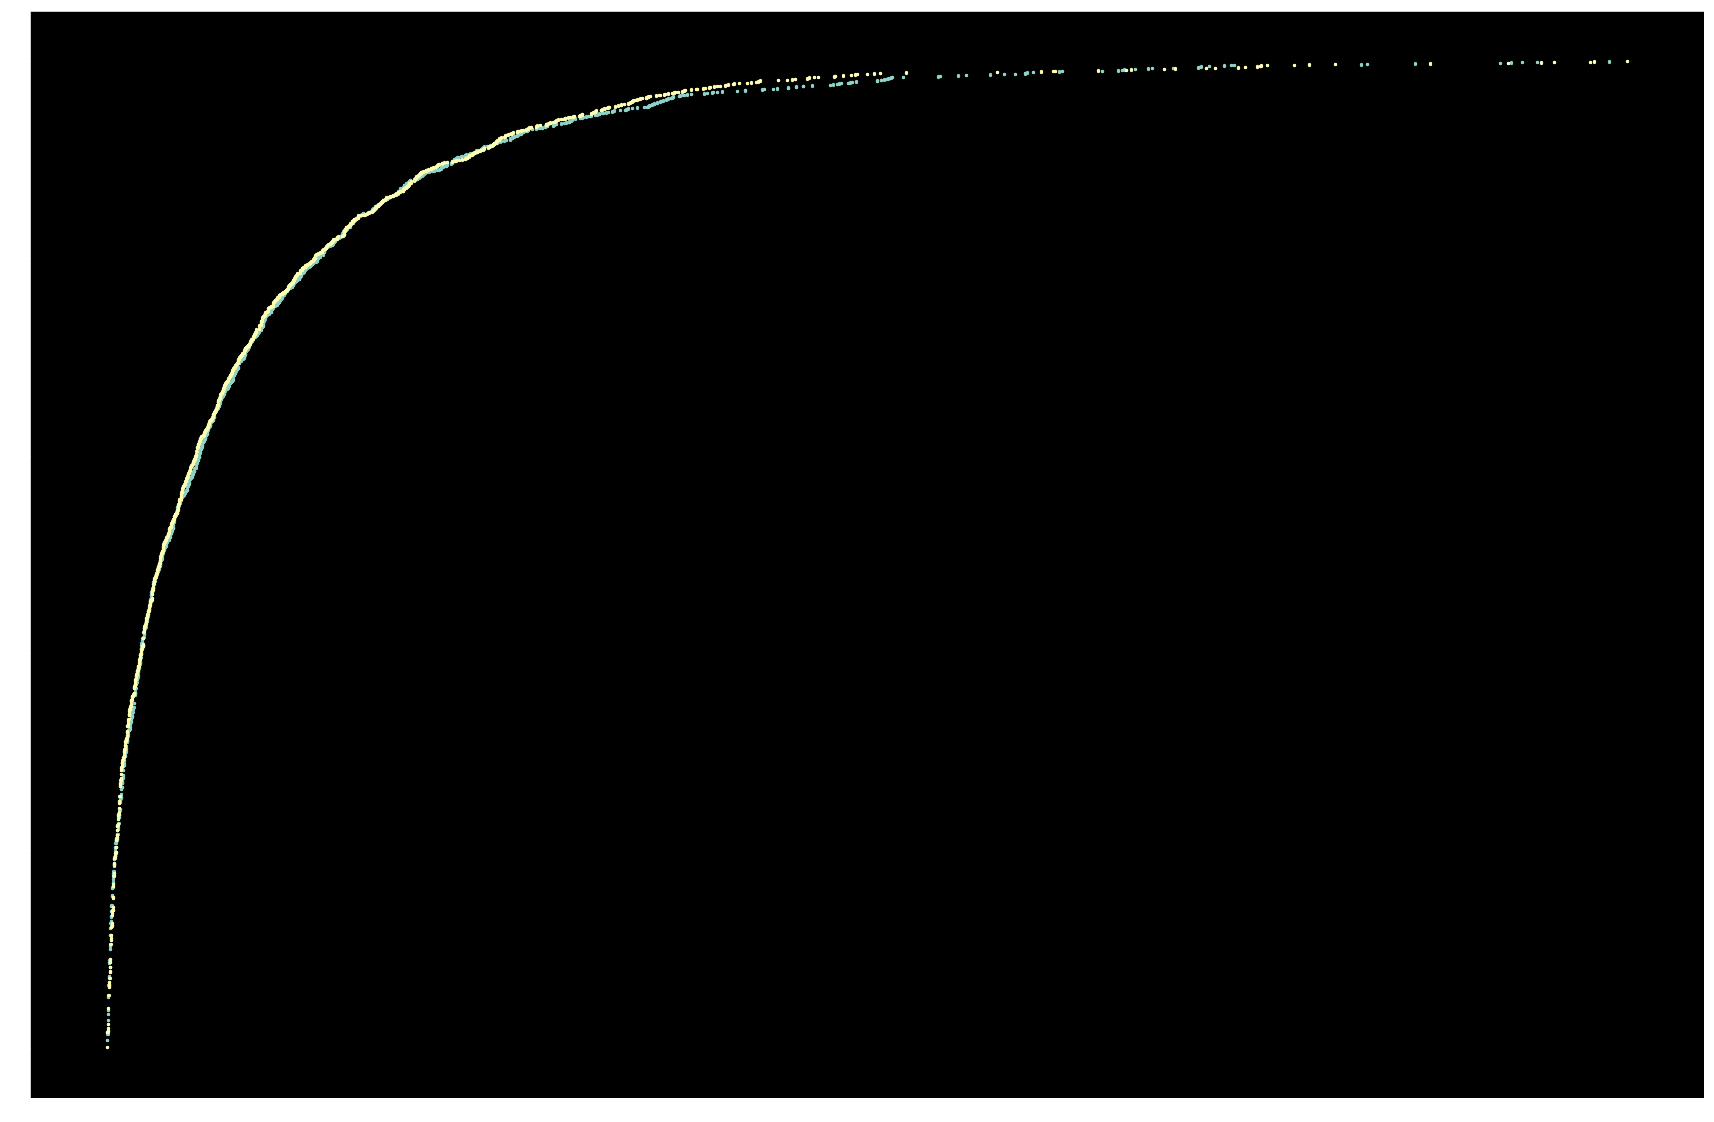

In [12]:
plt.figure(figsize=(30,20))
for i in range(X_meta.shape[1]-1):
    fpr, tpr, th = roc_curve(X_meta[:len(train),-1],X_meta[:len(train),i])
    plt.scatter(fpr,tpr,s=5)

In [13]:
meta_df = pd.DataFrame(X_meta,columns=[str(i) for i in range(len(list_stacks))]+['Default'])
numericals = list(meta_df.columns)
numericals.remove('Default')
target = 'Default'

In [14]:
meta_df['avg_predictions'] = X_meta[:,:-1].mean(axis=1)
numericals.append('avg_predictions')
meta_df['min_predictions'] = X_meta[:,:-1].min(axis=1)
numericals.append('min_predictions')
meta_df['max_predictions'] = X_meta[:,:-1].max(axis=1)
numericals.append('max_predictions')
meta_df['std_predictions'] = X_meta[:,:-1].std(axis=1)
numericals.append('std_predictions')

In [15]:
K = NearestNeighbors(50)
K.fit(X_meta[:,:-1])
neighbours = K.kneighbors(X_meta[:,:-1])
meta_df['average_distance_neighbours']=neighbours[0].mean(axis=1)
numericals.append('average_distance_neighbours')

In [16]:
features = numericals

In [17]:
matrix = meta_df[features].values
X = matrix[:N,:]
X_test = matrix[N:,:]
y = X_meta[:N,-1]

In [18]:
# Individual ROC AUC
for i in range(len(list_stacks)):
    print(roc_auc_score(y,X_meta[:len(train),i]))

0.9144004434403682
0.916755688416225


In [19]:
#Simple blend
avg_roc = roc_auc_score(y,X_meta[:len(train),:-1].mean(axis=1))
print(avg_roc)
test['Default'] = X_meta[len(train):,:-1].mean(axis=1)
test[['ID_CPTE','Default']].to_csv('EnsemblePredictions/'+f'{avg_roc:.5f}_'+'stackfull_blend.csv',index=False)

0.9174786378361609


In [20]:
X_meta2 = np.zeros((X_meta.shape[0],4))
X_meta2[:,-1] = X_meta[:,-1]

In [38]:
#Simple linear regression
rocs = []
lr_meta = LogisticRegression(C=0.01)
kf = KFold(10,shuffle=True,random_state=seed)

for train_idx, val_idx in kf.split(X):
    
    X_tr = X[train_idx]
    y_tr = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    
    lr_meta.fit(X=X_tr,y=y_tr)
    
    predict_tr = lr_meta.predict_proba(X_tr)[:,1]
    roc_auc_tr = roc_auc_score(y_tr,predict_tr)
    predict_val = lr_meta.predict_proba(X_val)[:,1]    
    roc_auc = roc_auc_score(y_val,predict_val)
    X_meta2[val_idx,0] = predict_val
    
    print('TRAIN:',roc_auc_tr,'VAL:',roc_auc)
    rocs.append(roc_auc)

avg_roc = sum(rocs)/len(rocs)
print('Average ROC:',avg_roc)

lr_meta.fit(X=X,y=y)
start_pred = time.time()
test['Default'] = lr_meta.predict(X_test)
print((time.time()-start_pred))
test[['ID_CPTE','Default']].to_csv('EnsemblePredictions/'+f'{avg_roc:.5f}_'+'stackfull_LR.csv',index=False)

TRAIN: 0.9166901905217862 VAL: 0.9245079662605435
TRAIN: 0.9161691046386579 VAL: 0.9290813335817402
TRAIN: 0.9174674995870599 VAL: 0.9172066687637623
TRAIN: 0.9177778611893094 VAL: 0.9144754353943265
TRAIN: 0.9189337472087296 VAL: 0.9077032395041434
TRAIN: 0.9167450013419217 VAL: 0.9241634278130628
TRAIN: 0.9182720496589111 VAL: 0.9113710818256273
TRAIN: 0.9176481936022679 VAL: 0.9162791333843965
TRAIN: 0.9172935979142527 VAL: 0.9196494029857716
TRAIN: 0.9180027733047057 VAL: 0.9133115754596464
Average ROC: 0.917774926497302
0.0005013942718505859


In [22]:
print((time.time()-start))

0.670283317565918


In [45]:
fpr,tpr,th = roc_curve(X_meta[:len(train),-1],X_meta2[:len(train),0])
pd.DataFrame(np.stack([fpr,tpr,th],axis=1),columns=['FPR','TPR','Threshold']).to_csv('Roc.csv')

In [46]:
X_meta[:len(train),-1].mean()

0.19336134453781512